In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/IllnessRecognition/app/dl

/content/drive/MyDrive/IllnessRecognition/app/dl


In [6]:
IMAGE_SIZE = [163, 220]

In [7]:
from local_lib.dataset import retreiveDatasetFromCsv
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
import numpy as np
from sklearn.preprocessing import MinMaxScaler


dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

In [8]:
pipeline = Pipeline([
    ('non_zero_tr', NonZeroTransformer()),
    ('mask_tr', MaskSeuilTransformer(strategy="combined")),
    ('minmax', MinMaxScaler())
    ])

In [9]:
# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))


In [10]:
import copy

# Make a copy of the list
y_simpler = copy.deepcopy(y)
y_simpler[y_simpler == 2] = 1
np.unique(y_simpler)

y = y_simpler

In [11]:
import keras
from tensorflow.keras.callbacks import Callback

class BatchLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_acc = []
        self.epoch_acc = []
        self.epoch_val_acc = []
        self.batch_losses = []
        self.batch_precision = []
        self.batch_recall = []
        self.logs = []

    def on_batch_end(self, batch, logs=None):
        self.batch_acc.append(logs.get('binary_accuracy'))
        self.batch_losses.append(logs.get('loss'))
        self.batch_precision.append(logs.get('precision'))
        self.batch_recall.append(logs.get('recall'))
        self.logs.append(logs)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_acc.append(logs.get('binary_accuracy'))
        self.epoch_val_acc.append(logs.get('val_accuracy'))

checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

batch_loss_logger = BatchLogger()


In [12]:
initial_learning_rate = 0.010
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [13]:
METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        ]

In [14]:
#Reshape to 2D
X_reshaped = X.reshape((X.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

In [15]:
X_reshaped.shape

(5856, 163, 220, 1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


In [17]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Flatten(),

    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.7),

    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    #layers.Dropout(0.3),

    layers.Dense(1, activation="sigmoid")
])

In [18]:
import tensorflow as tf

# Compile the model with the learning rate schedule
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy', metrics=METRICS)

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def fitModelAndPlot(model,X_train,y_train, X_test, y_test, nb_epochs = 10, batch_size = 32, validation_split_percentage = 0.2, useClassWeights = False, useDataGeneration = False):
    if useClassWeights:
        class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(enumerate(class_weights))
        history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                            validation_split=validation_split_percentage, callbacks=[checkpoint_cb, early_stopping_cb, batch_loss_logger],
                            class_weight=class_weight_dict)
    elif useDataGeneration:
      datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
      )

      train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
      history = model.fit(train_generator, epochs=nb_epochs, validation_data=(X_test, y_test),
                callbacks=[checkpoint_cb, early_stopping_cb])
    else:
        history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                            validation_split=validation_split_percentage, callbacks=[checkpoint_cb, early_stopping_cb, batch_loss_logger])

    test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc}, Test Loss: {test_loss}, Test Recall: {test_recall}, Test Precision: {test_precision}")

    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 14))

    nb_rows = 5

    plt.subplot(nb_rows, 2, 1)
    plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(nb_rows, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(nb_rows, 2, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(nb_rows, 2, 4)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc='best')

    # plt.subplot(nb_rows, 2, 5)
    # plt.plot(batch_loss_logger.batch_losses, label='Batch Loss')
    # plt.title('Batch Loss During Training')
    # plt.xlabel('Batch')
    # plt.ylabel('Loss')
    # plt.legend(loc='best')

    # plt.subplot(nb_rows, 2, 6)
    # plt.plot(batch_loss_logger.batch_acc, label='Batch Accuracy')
    # plt.title('Batch Accuracy During Training')
    # plt.xlabel('Batch')
    # plt.ylabel('Accuracy')
    # plt.legend(loc='best')

    # plt.subplot(nb_rows, 2, 7)
    # plt.plot(batch_loss_logger.batch_precision, label='Batch Precision')
    # plt.title('Batch Precision Training')
    # plt.xlabel('Batch')
    # plt.ylabel('Precision')
    # plt.legend(loc='best')

    # plt.subplot(nb_rows, 2, 8)
    # plt.plot(batch_loss_logger.batch_recall, label='Batch Recall')
    # plt.title('Batch Recall Training')
    # plt.xlabel('Batch')
    # plt.ylabel('Recall')
    # plt.legend(loc='best')

    # plt.subplot(nb_rows, 2, 9)
    # plt.plot(batch_loss_logger.epoch_acc, label='Epoch Accuracy and Validation Accuracy')
    # plt.plot(batch_loss_logger.epoch_val_acc, label='Epoch Validation Accuracy')
    # plt.title('Epoch Accuracy and Validation Accuracy Training')
    # plt.xlabel('Batch')
    # plt.ylabel('Accuracy and Validation Accuracy')
    # plt.legend(loc='best')

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')


    plt.tight_layout()
    plt.show()


Epoch 1/100
10/10 [==============================] - 50s 2s/step - loss: 0.7150 - binary_accuracy: 0.6061 - precision: 0.7600 - recall: 0.6711 - val_loss: 0.6061 - val_binary_accuracy: 0.7355 - val_precision: 0.7355 - val_recall: 1.0000
Epoch 2/100
10/10 [==============================] - 20s 2s/step - loss: 0.4561 - binary_accuracy: 0.7863 - precision: 0.8612 - recall: 0.8423 - val_loss: 2.9120 - val_binary_accuracy: 0.2645 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 20s 2s/step - loss: 0.3314 - binary_accuracy: 0.8604 - precision: 0.8992 - recall: 0.9103 - val_loss: 2.5117 - val_binary_accuracy: 0.2645 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 20s 2s/step - loss: 0.2861 - binary_accuracy: 0.8807 - precision: 0.9124 - recall: 0.9249 - val_loss: 1.2167 - val_binary_accuracy: 0.2645 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
10/10 [=========

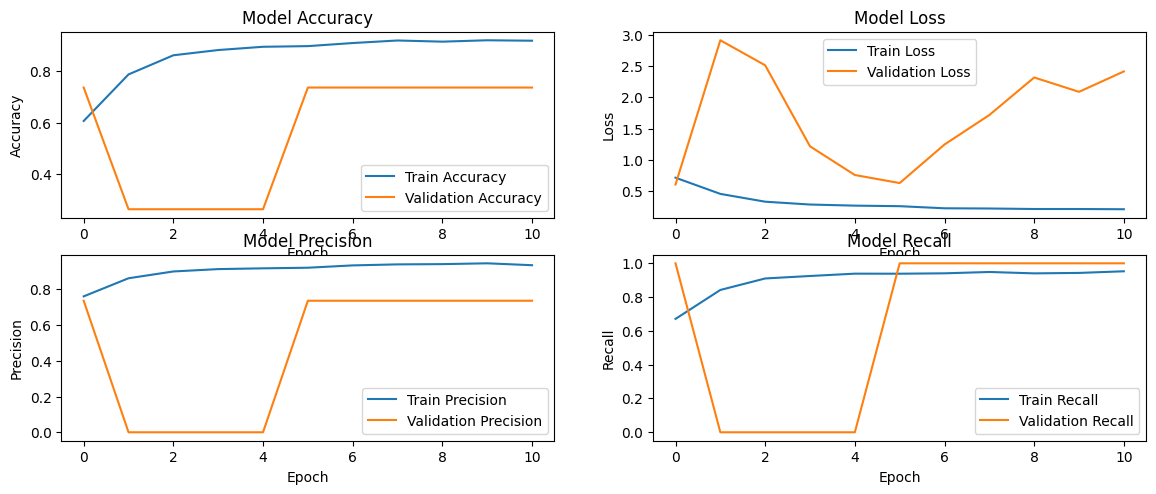

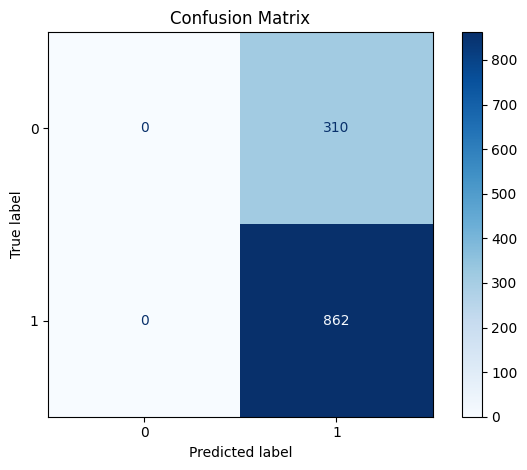

In [20]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512,useDataGeneration=True)

Epoch 1/100
6/8 [=====================>........] - ETA: 2s - loss: 0.4649 - binary_accuracy: 0.7822 - precision: 0.9148 - recall: 0.7744

8/8 [==============================] - 26s 3s/step - loss: 0.4392 - binary_accuracy: 0.7945 - precision: 0.9224 - recall: 0.7850 - val_loss: 1.5392 - val_binary_accuracy: 0.2828 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.3516 - binary_accuracy: 0.8489 - precision: 0.9521 - recall: 0.8353 - val_loss: 2.5491 - val_binary_accuracy: 0.2828 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.2593 - binary_accuracy: 0.8999 - precision: 0.9632 - recall: 0.8974 - val_loss: 1.9836 - val_binary_accuracy: 0.2828 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.2044 - binary_accuracy: 0.9253 - precision: 0.9749 - recall: 0.9215 - val_loss: 0.9938 - val_binary_accuracy: 0.2828 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
8/8 [==========================

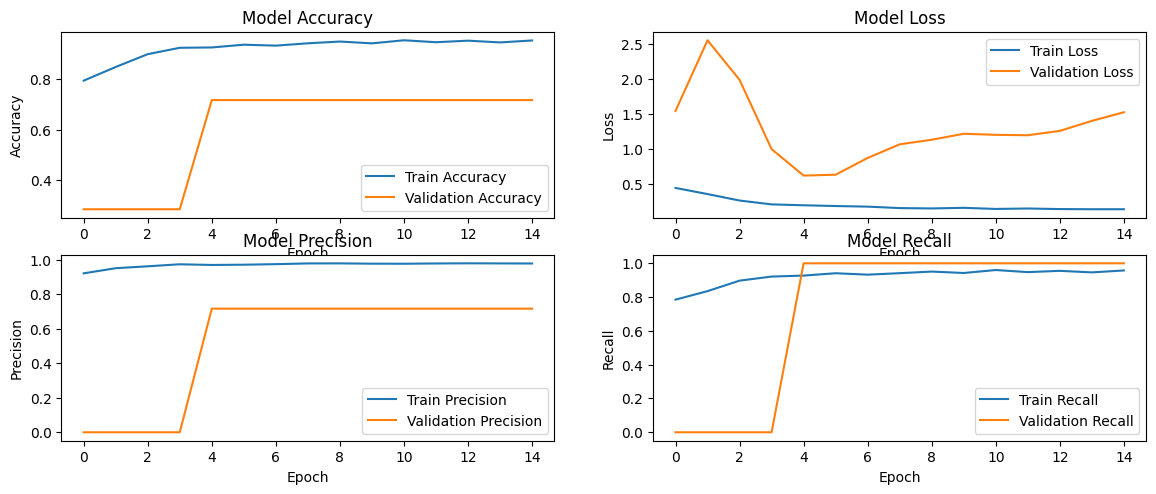

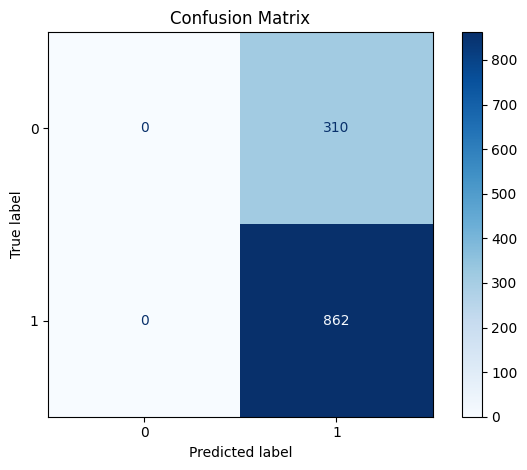

In [21]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512,useClassWeights=True)

Epoch 1/100
6/8 [=====================>........] - ETA: 2s - loss: 0.1786 - binary_accuracy: 0.9398 - precision: 0.9689 - recall: 0.9477

8/8 [==============================] - 9s 1s/step - loss: 0.1751 - binary_accuracy: 0.9410 - precision: 0.9687 - recall: 0.9500 - val_loss: 0.8752 - val_binary_accuracy: 0.7172 - val_precision: 0.7172 - val_recall: 1.0000
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.1576 - binary_accuracy: 0.9426 - precision: 0.9510 - recall: 0.9715 - val_loss: 1.0628 - val_binary_accuracy: 0.7172 - val_precision: 0.7172 - val_recall: 1.0000
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.1330 - binary_accuracy: 0.9520 - precision: 0.9617 - recall: 0.9730 - val_loss: 1.2717 - val_binary_accuracy: 0.7172 - val_precision: 0.7172 - val_recall: 1.0000
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.1445 - binary_accuracy: 0.9509 - precision: 0.9647 - recall: 0.9682 - val_loss: 1.2893 - val_binary_accuracy: 0.7172 - val_precision: 0.7172 - val_recall: 1.0000
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.1235

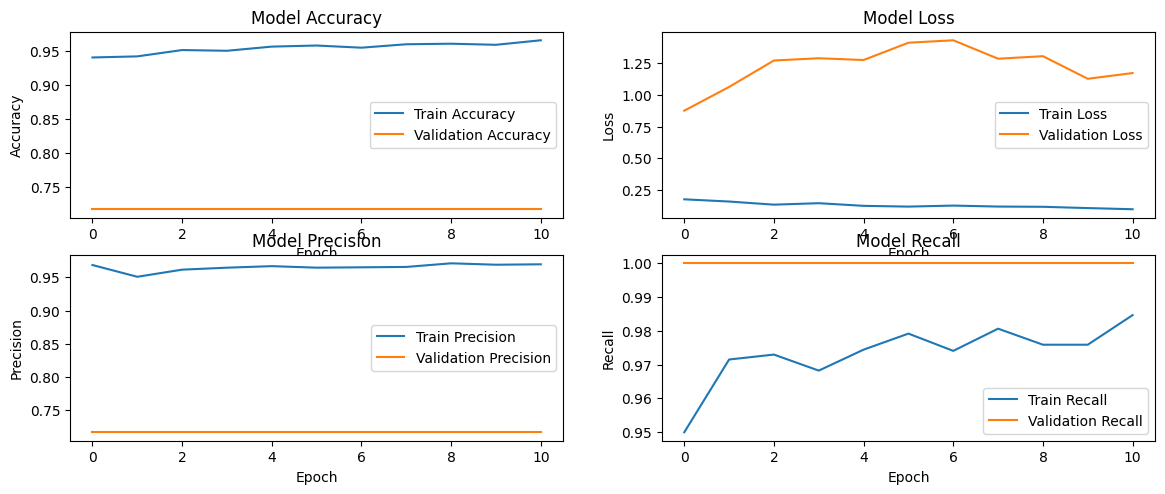

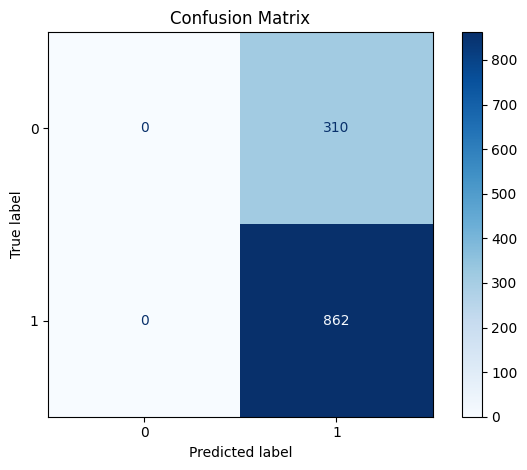

In [22]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512)

Epoch 1/100
 6/59 [==>...........................] - ETA: 7s - loss: 0.1882 - binary_accuracy: 0.9375 - precision: 0.9623 - recall: 0.9558

59/59 [==============================] - 14s 206ms/step - loss: 0.2536 - binary_accuracy: 0.9037 - precision: 0.9265 - recall: 0.9430 - val_loss: 46.4490 - val_binary_accuracy: 0.2850 - val_precision: 1.0000 - val_recall: 0.0030
Epoch 2/100
59/59 [==============================] - 9s 148ms/step - loss: 0.2088 - binary_accuracy: 0.9202 - precision: 0.9414 - recall: 0.9500 - val_loss: 18.0204 - val_binary_accuracy: 0.5464 - val_precision: 1.0000 - val_recall: 0.3676
Epoch 3/100
59/59 [==============================] - 9s 156ms/step - loss: 0.1728 - binary_accuracy: 0.9386 - precision: 0.9517 - recall: 0.9650 - val_loss: 0.2588 - val_binary_accuracy: 0.9114 - val_precision: 0.9594 - val_recall: 0.9152
Epoch 4/100
59/59 [==============================] - 9s 148ms/step - loss: 0.1571 - binary_accuracy: 0.9424 - precision: 0.9549 - recall: 0.9668 - val_loss: 6.4393 - val_binary_accuracy: 0.4184 - val_precision: 1.0000 - val_recall: 0.1890
Epoch 5/100
59/59 [==============================] - 

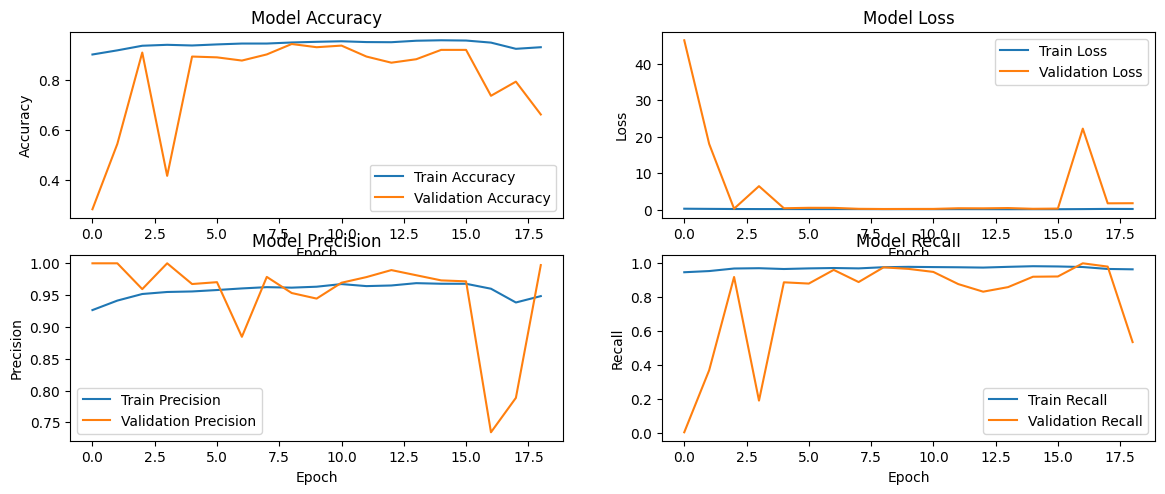

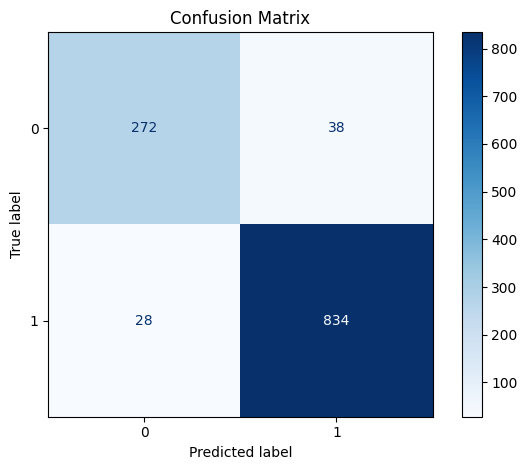

In [23]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,64)

Epoch 1/100
 6/59 [==>...........................] - ETA: 7s - loss: 0.1274 - binary_accuracy: 0.9479 - precision: 0.9550 - recall: 0.9753

59/59 [==============================] - 10s 159ms/step - loss: 0.1301 - binary_accuracy: 0.9530 - precision: 0.9621 - recall: 0.9741 - val_loss: 0.3382 - val_binary_accuracy: 0.9093 - val_precision: 0.8950 - val_recall: 0.9896
Epoch 2/100
59/59 [==============================] - 9s 152ms/step - loss: 0.1178 - binary_accuracy: 0.9568 - precision: 0.9670 - recall: 0.9741 - val_loss: 0.2220 - val_binary_accuracy: 0.9370 - val_precision: 0.9263 - val_recall: 0.9911
Epoch 3/100
59/59 [==============================] - 10s 163ms/step - loss: 0.1026 - binary_accuracy: 0.9621 - precision: 0.9703 - recall: 0.9781 - val_loss: 0.1703 - val_binary_accuracy: 0.9488 - val_precision: 0.9548 - val_recall: 0.9747
Epoch 4/100
59/59 [==============================] - 9s 151ms/step - loss: 0.1292 - binary_accuracy: 0.9514 - precision: 0.9624 - recall: 0.9715 - val_loss: 0.2177 - val_binary_accuracy: 0.9349 - val_precision: 0.9225 - val_recall: 0.9926
Epoch 5/100
59/59 [==============================] - 9

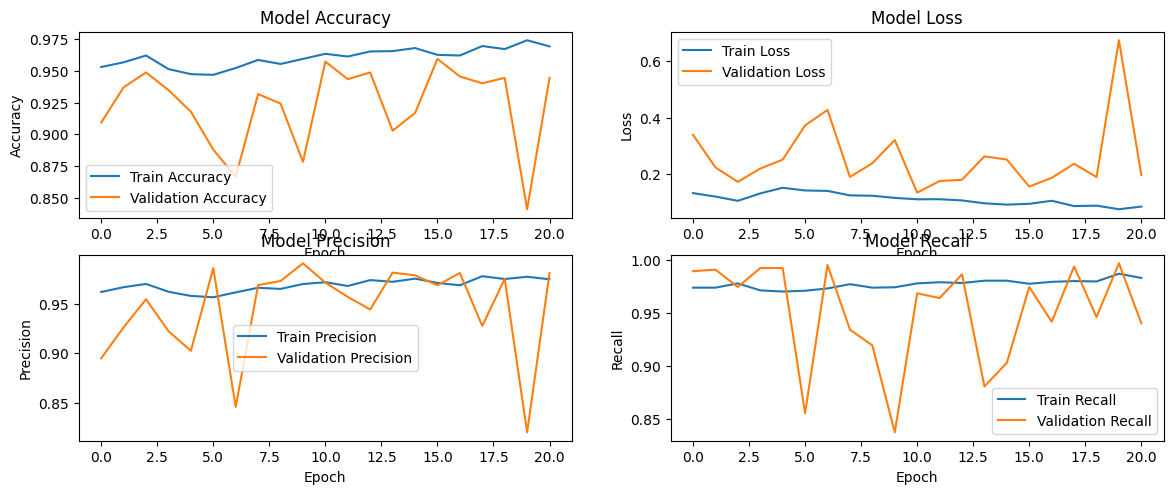

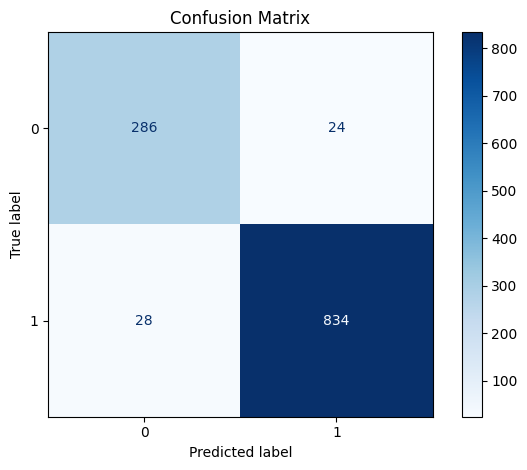

In [24]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,64, useClassWeights=True)

In [ ]:
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,64, useDataGeneration=True)

Epoch 1/100
74/74 [==============================] - 21s 278ms/step - loss: 0.3460 - binary_accuracy: 0.8597 - precision: 0.8883 - recall: 0.9235 - val_loss: 0.7202 - val_binary_accuracy: 0.7312 - val_precision: 0.7401 - val_recall: 0.9780
Epoch 2/100
74/74 [==============================] - 19s 252ms/step - loss: 0.2531 - binary_accuracy: 0.8958 - precision: 0.9225 - recall: 0.9355 - val_loss: 0.2140 - val_binary_accuracy: 0.9215 - val_precision: 0.9415 - val_recall: 0.9524
Epoch 3/100
74/74 [==============================] - 19s 256ms/step - loss: 0.2503 - binary_accuracy: 0.9046 - precision: 0.9251 - recall: 0.9455 - val_loss: 0.3267 - val_binary_accuracy: 0.8686 - val_precision: 0.9823 - val_recall: 0.8364
Epoch 4/100
74/74 [==============================] - 20s 271ms/step - loss: 0.2500 - binary_accuracy: 0.8999 - precision: 0.9289 - recall: 0.9340 - val_loss: 1.4999 - val_binary_accuracy: 0.7014 - val_precision: 0.9867 - val_recall: 0.6021
Epoch 5/100
74/74 [=====================